# Hacking Cluster

A large technology firm needs your help, they've been hacked! Luckily their forensic engineers have grabbed valuable data about the hacks, including information like session time,locations, wpm typing speed, etc. The forensic engineer relates to you what she has been able to figure out so far, she has been able to grab meta data of each session that the hackers used to connect to their servers. These are the features of the data:

* 'Session_Connection_Time': How long the session lasted in minutes
* 'Bytes Transferred': Number of MB transferred during session
* 'Kali_Trace_Used': Indicates if the hacker was using Kali Linux
* 'Servers_Corrupted': Number of server corrupted during the attack
* 'Pages_Corrupted': Number of pages illegally accessed
* 'Location': Location attack came from (Probably useless because the hackers used VPNs)
* 'WPM_Typing_Speed': Their estimated typing speed based on session logs.


The technology firm has 3 potential hackers that perpetrated the attack. Their certain of the first two hackers but they aren't very sure if the third hacker was involved or not. They have requested your help! Can you help figure out whether or not the third suspect had anything to do with the attacks, or was it just two hackers?

**One last key fact, the forensic engineer knows that the hackers trade off attacks. Meaning they should each have roughly the same amount of attacks. For example if there were 100 total attacks, then in a 2 hacker situation each should have about 50 hacks, in a three hacker situation each would have about 33 hacks. The engineer believes this is the key element to solving this, but doesn't know how to distinguish this unlabeled data into groups of hackers.**

In [15]:
################## Initialization ###################

# Session
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('cluster').getOrCreate()

# Model
from pyspark.ml.clustering import KMeans

# Vectorizer
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

# Scaling
from pyspark.ml.feature import StandardScaler

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Pandas
import numpy as np
import pandas as pd


In [3]:
#################### Bring in Data #######################
# Loads data.
data = spark.read.csv("hack_data.csv",header=True,inferSchema=True)
data.printSchema()

root
 |-- Session_Connection_Time: double (nullable = true)
 |-- Bytes Transferred: double (nullable = true)
 |-- Kali_Trace_Used: integer (nullable = true)
 |-- Servers_Corrupted: double (nullable = true)
 |-- Pages_Corrupted: double (nullable = true)
 |-- Location: string (nullable = true)
 |-- WPM_Typing_Speed: double (nullable = true)



In [20]:
data.show(5)

+-----------------------+-----------------+---------------+-----------------+---------------+--------------------+----------------+
|Session_Connection_Time|Bytes Transferred|Kali_Trace_Used|Servers_Corrupted|Pages_Corrupted|            Location|WPM_Typing_Speed|
+-----------------------+-----------------+---------------+-----------------+---------------+--------------------+----------------+
|                    8.0|           391.09|              1|             2.96|            7.0|            Slovenia|           72.37|
|                   20.0|           720.99|              0|             3.04|            9.0|British Virgin Is...|           69.08|
|                   31.0|           356.32|              1|             3.71|            8.0|             Tokelau|           70.58|
|                    2.0|           228.08|              1|             2.48|            8.0|             Bolivia|            70.8|
|                   20.0|            408.5|              0|             3.57

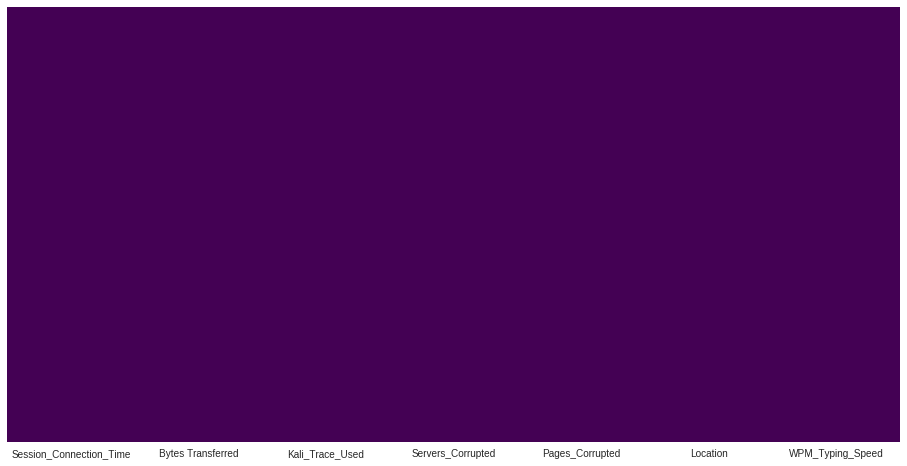

In [18]:
# Plot to see if there is any missing data.
plot_data = data.toPandas()
plt.figure(figsize=(16,8))
sns.heatmap(plot_data.isnull(), yticklabels=False, cbar=False, cmap='viridis')

In [19]:
data.columns

['Session_Connection_Time',
 'Bytes Transferred',
 'Kali_Trace_Used',
 'Servers_Corrupted',
 'Pages_Corrupted',
 'Location',
 'WPM_Typing_Speed']

### Feature Engineering

In [21]:
# Check Localtion categorization
data.groupBy('Location').count().show()

+--------------------+-----+
|            Location|count|
+--------------------+-----+
|            Anguilla|    1|
|            Paraguay|    2|
|               Macao|    2|
|Heard Island and ...|    2|
|               Yemen|    1|
|             Tokelau|    2|
|              Sweden|    3|
|French Southern T...|    3|
|            Kiribati|    1|
|              Guyana|    2|
|         Philippines|    3|
|            Malaysia|    2|
|           Singapore|    1|
|United States Vir...|    6|
|              Turkey|    1|
|      Western Sahara|    2|
|              Malawi|    2|
|                Iraq|    3|
|Northern Mariana ...|    3|
|             Germany|    1|
+--------------------+-----+
only showing top 20 rows



In [23]:
##################### Format Data ###########################
feature_columns = data.select(['Session_Connection_Time',
 'Bytes Transferred',
 'Kali_Trace_Used',
 'Servers_Corrupted',
 'Pages_Corrupted',
  'WPM_Typing_Speed'])

# Vectorize this
assembler = VectorAssembler(inputCols=['Session_Connection_Time',
 'Bytes Transferred',
 'Kali_Trace_Used',
 'Servers_Corrupted',
 'Pages_Corrupted',
  'WPM_Typing_Speed'],outputCol='features')

final_data = assembler.transform(data)

In [24]:
######################## Scale Data ##############################
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=False)
# Compute summary statistics by fitting the StandardScaler
scalerModel = scaler.fit(final_data)
# Normalize each feature to have unit standard deviation.
final_data = scalerModel.transform(final_data)

<function matplotlib.pyplot.show(*args, **kw)>

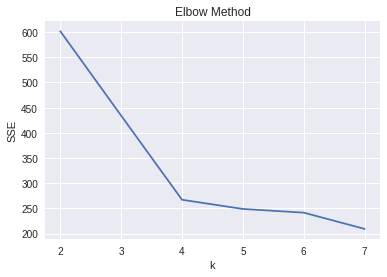

In [27]:
######################## Run Model #############################

# Will use the elbow method
sse = {}
K = range(2,8)
for k in K:
    kmeans = KMeans(featuresCol='scaledFeatures',k=k).fit(final_data)
    sse[k]= kmeans.computeCost(final_data)
    
# Plot
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel('k')
plt.ylabel('SSE')
plt.title('Elbow Method')
plt.show


Elbow method is showing the number of clusters is 4.

In [28]:
# Lets see how the attacks are evenly split
kmeans_2 = KMeans(featuresCol='scaledFeatures',k=2).fit(final_data)
kmeans_3 = KMeans(featuresCol='scaledFeatures',k=3).fit(final_data)
kmeans_4 = KMeans(featuresCol='scaledFeatures',k=4).fit(final_data)

In [30]:
kmeans_2.transform(final_data).groupBy('prediction').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1|  167|
|         0|  167|
+----------+-----+



In [31]:
kmeans_3.transform(final_data).groupBy('prediction').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1|  167|
|         2|   83|
|         0|   84|
+----------+-----+



In [32]:
kmeans_4.transform(final_data).groupBy('prediction').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1|   79|
|         3|   88|
|         2|   84|
|         0|   83|
+----------+-----+



This is where experience comes in. It was either 2 or 4 hackers. 